## Imports and definitions

In [17]:
from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from scipy.cluster import hierarchy as hc
from treeinterpreter import treeinterpreter as ti

from sklearn import metrics
import feather
import pdpbox.pdp as pdp
from plotnine import *

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import os
from contextlib import contextmanager

plt.rcParams["figure.figsize"] = (10, 6)
set_plot_sizes(12, 14, 16)
np.set_printoptions(precision=5)
pd.set_option("display.precision", 5)
%precision 5

# constants #################################################################
PATH = 'data/bulldozers/'
DF_RAW_PATH = 'tmp/bulldozers-raw'
N_VALID = 12_000


# defines: ##################################################################
@contextmanager
def rf_samples(n='all', verbose=None):
    if isinstance(n, int) and n > 0:
        set_rf_samples(n)
        if verbose:
            print('set_rf_samples', n)
    try:
        yield
    finally:
        if isinstance(n, int) and n > 0:
            reset_rf_samples()
            if verbose:
                print('reset_rf_samples')


def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns",
                           1000):
        display(df)


def split_vals(a, n):
    return a[:n].copy(), a[n:].copy()


def rmse(x, y):
    return math.sqrt(((x - y)**2).mean())


def do_print_score(m, X_train, y_train, X_valid, y_valid):
    res = [
        rmse(m.predict(X_train), y_train),
        rmse(m.predict(X_valid), y_valid),
        m.score(X_train, y_train),
        m.score(X_valid, y_valid),
    ]
    if hasattr(m, "oob_score_"):
        res.append(m.oob_score_)
    print(np.array(res))


class AttrDict(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__


def do_proc_df(
        df_raw,
        n_valid,
        y_fld=None,
        skip_flds=None,
        ignore_flds=None,
        do_scale=False,
        na_dict=None,
        preproc_fn=None,
        max_n_cat=None,
        subset=None,
        mapper=None,
        to_keep=None,
):
    df_trn, y_trn, nas = proc_df(
        df=df_raw,
        y_fld=y_fld,
        skip_flds=skip_flds,
        ignore_flds=ignore_flds,
        do_scale=do_scale,
        na_dict=na_dict,
        preproc_fn=preproc_fn,
        max_n_cat=max_n_cat,
        subset=subset,
        mapper=mapper)
    if not (to_keep is None):
        df_trn = df_trn[to_keep]
    n_trn = len(df_trn) - n_valid
    X_train, X_valid = split_vals(df_trn, n_trn)
    y_train, y_valid = split_vals(y_trn, n_trn)
    raw_train, raw_valid = split_vals(df_raw, n_trn)
    return AttrDict(locals())


# variant with limited max_depth
def do_draw_tree(tree,
                 df,
                 max_depth=2,
                 size=10,
                 ratio=0.6,
                 precision=3,
                 rotate=True):
    s = export_graphviz(
        tree,
        out_file=None,
        feature_names=df.columns,
        filled=True,
        special_characters=True,
        rotate=rotate,
        max_depth=max_depth,
        precision=precision,
    )
    display(
        graphviz.Source(
            re.sub("Tree {", f"Tree {{ size={size}; ratio={ratio}", s)))

# Random forest from scratch

In [18]:
!ls -al {DF_RAW_PATH}

-rw-r--r-- 1 fastai fastai 69728208 Mar 20 21:44 tmp/bulldozers-raw


## Load in our data from last lesson

In [19]:
DF_RAW = pd.read_feather('tmp/bulldozers-raw')
dattr = do_proc_df(DF_RAW, N_VALID, 'SalePrice')

In [20]:
x_sub = dattr.X_train[['YearMade', 'MachineHoursCurrentMeter']]
x_sub.head()

,YearMade,MachineHoursCurrentMeter
0,2004,68.0
1,1996,4640.0
2,2001,2838.0
3,2001,3486.0
4,2007,722.0


## Basic data structures

In [21]:
class TreeEnsemble():
    def __init__(self, x, y, n_trees, sample_sz, min_leaf=5, rnd_seed=42):
        np.random.seed(rnd_seed)
        self.x, self.y = x, y
        self.n_trees, self.sample_sz, self.min_leaf = n_trees, sample_sz, min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]

    def create_tree(self):
        rnd_idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        return DecisionTree(
            self.x.iloc[rnd_idxs], self.y[rnd_idxs], min_leaf=self.min_leaf)

    def predict(self, x):
        return np.mean([t.predict(x) for t in self.trees], axis=0)
    
    

In [48]:
class DecisionTree():
    def __init__(self, x, y, idxs=None, min_leaf=5):
        if idxs is None: idxs = np.arange(len(y))
        self.idxs = idxs
        self.x, self.y = x, y
        self.min_leaf = min_leaf
        self.n, self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()

    def __repr__(self):
        s = f'n:{self.n}; val:{self.val:.5f}'
        if not self.is_leaf:
            s += f'; score:{self.score:.5f}; split:{self.split:.5f}; var:{self.split_name}'
        return s

    @property
    def split_name(self):
        return self.x.columns[self.var_idx]

    @property
    def split_col(self):
        return self.x.values[self.idxs, self.var_idx]

    @property
    def is_leaf(self):
        return self.score == float('inf')

    def find_varsplit(self):
        for i in range(self.c):
            self.find_better_split(i)

    def find_better_split(self, car_idx):
        pass

In [28]:
m = TreeEnsemble(dattr.X_train, dattr.y_train, n_trees=10, sample_sz=1000, min_leaf=3)

In [29]:
m.trees[0]


n:1000; val:10.079014121552744

In [31]:
m.trees[0].idxs.shape

(1000,)

## Single branch

### Find best split given variable

In [50]:
ens = TreeEnsemble(x_sub, dattr.y_train, n_trees=1, sample_sz=1000)
tree = ens.trees[0]
x_samp, y_samp = tree.x, tree.y
x_samp.columns

Index(['YearMade', 'MachineHoursCurrentMeter'], dtype='object')

In [54]:
tree

n:1000; val:10.07901

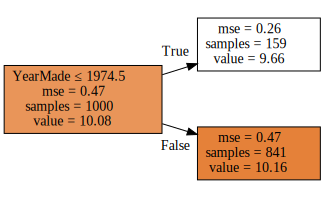

In [63]:
m=RandomForestRegressor(n_estimators=1, max_depth=1, bootstrap=False)
m.fit(x_samp, y_samp)
draw_tree(m.estimators_[0], x_samp, precision=2)

In [62]:
def find_better_split(self, var_idx):
    x, y = self.x.values[self.idxs, var_idx], self.y[self.idxs]
    for i in range(1, self.n - 1):
        lhs = x <= x[i]
        rhs = x > x[i]
        if rhs.sum() == 0: continue
        lhs_std = y[lhs].std()
        rhs_std = y[rhs].std()
        curr_score = lhs_std * lhs.sum() + rhs_std * rhs.sum()
        if curr_score < self.score:
            self.var_idx, self.score, self.split = var_idx, curr_score, x[i]

In [64]:
%timeit find_better_split(tree, 0)

61.9 ms ± 2.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [61]:
tree

n:1000; val:10.07901; score:658.55102; split:1974.00000; var:YearMade

### Speeding things up

In [78]:
def find_better_split(self, var_idx):
    def std_agg(cnt, s1, s2):
        return np.sqrt((s2 / cnt) - (s1 / cnt)**2)

    x, y = self.x.values[self.idxs, var_idx], self.y[self.idxs]
    sort_idx = np.argsort(x)
    sort_y, sort_x = y[sort_idx], x[sort_idx]
    rhs_cnt, rhs_sum, rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
    lhs_cnt, lhs_sum, lhs_sum2 = 0, 0.0, 0.0
    for i in range(0, self.n - self.min_leaf):
        xi, yi = sort_x[i], sort_y[i]
        lhs_cnt += 1
        rhs_cnt -= 1
        lhs_sum += yi
        rhs_sum -= yi
        lhs_sum2 += yi**2
        rhs_sum2 -= yi**2
        if i < self.min_leaf - 1 or xi == sort_x[i + 1]:
            continue
        lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
        rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
        curr_score = lhs_std * lhs_cnt + rhs_std * rhs_cnt
        if curr_score < self.score:
            self.var_idx, self.score, self.split = var_idx, curr_score, xi

In [79]:
tree = TreeEnsemble(x_sub, dattr.y_train, 1, 1000).trees[0]
%timeit find_better_split(tree, 1)
tree

2.45 ms ± 40.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


n:1000; val:10.07901; score:681.01841; split:3744.00000; var:MachineHoursCurrentMeter

In [73]:
tree

n:1000; val:10.07901; score:681.01841; split:3744.00000; var:MachineHoursCurrentMeter

In [80]:
tree = TreeEnsemble(x_sub, dattr.y_train, 1, 1000).trees[0]
%timeit find_better_split(tree, 0)
tree

1.96 ms ± 29.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


n:1000; val:10.07901; score:658.55102; split:1974.00000; var:YearMade

In [82]:
# Monkey patch
DecisionTree.find_better_split = find_better_split

In [84]:
tree = TreeEnsemble(x_sub, dattr.y_train, 1, 1000).trees[0]
tree

n:1000; val:10.07901; score:658.55102; split:1974.00000; var:YearMade

## Full single tree

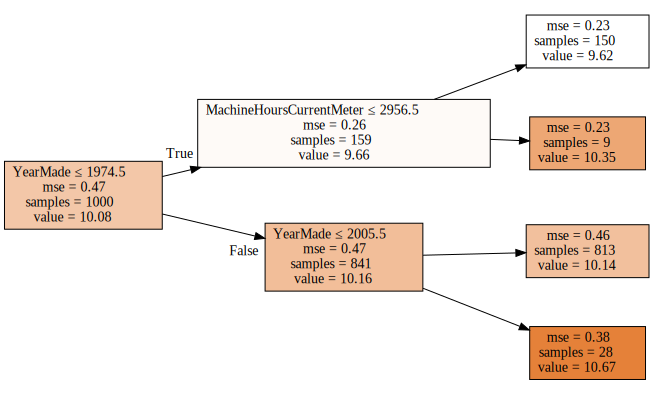

In [85]:
m = RandomForestRegressor(n_estimators=1, max_depth=2, bootstrap=False)
m.fit(x_samp, y_samp)
draw_tree(m.estimators_[0], x_samp, precision=2)

In [86]:
def find_varsplit(self):
    for i in range(self.c):
        self.find_better_split(i)
    if self.is_leaf: return
    x = self.split_col
    lhs = np.nonzero(x <= self.split)[0]
    rhs = np.nonzero(x > self.split)[0]
    self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs])
    self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs])
DecisionTree.find_varsplit = find_varsplit

In [88]:
tree = TreeEnsemble(x_sub, dattr.y_train, 1, 1000).trees[0]; tree

n:1000; val:10.07901; score:658.55102; split:1974.00000; var:YearMade

In [90]:
tree.lhs, tree.rhs

(n:159; val:9.66089; score:76.82697; split:2800.00000; var:MachineHoursCurrentMeter,
 n:841; val:10.15806; score:571.48035; split:2005.00000; var:YearMade)

## Predictions

In [92]:
cols = [
    'MachineID', 'YearMade', 'MachineHoursCurrentMeter', 'ProductSize',
    'Enclosure', 'Coupler_System', 'saleYear'
]

%time tree = TreeEnsemble(dattr.X_train[cols], dattr.y_train, 1, 1000).trees[0]
x_samp, y_samp = tree.x, tree.y

CPU times: user 375 ms, sys: 71 µs, total: 375 ms
Wall time: 374 ms


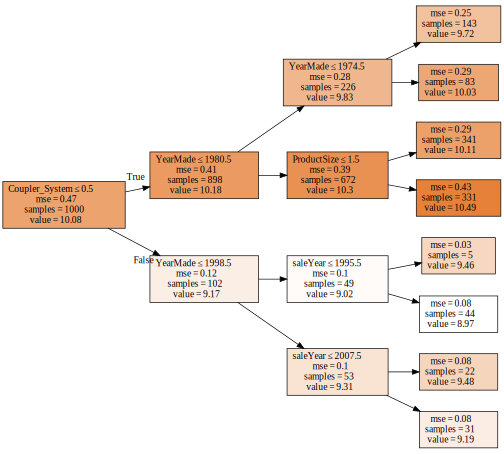

In [93]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False)
m.fit(x_samp, y_samp)
draw_tree(m.estimators_[0], x_samp, precision=2, ratio=0.9, size=7)

In [94]:
def predict(self, x):
    return np.array([self.predict_row(xi) for xi in x])


DecisionTree.predict = predict

In [95]:
def predict_row(self, xi):
    if self.is_leaf: return self.val
    t = self.lhs if xi[self.var_idx] <= self.split else self.rhs
    return t.predict_row(xi)


DecisionTree.predict_row = predict_row

In [96]:
%time preds = tree.predict(dattr.X_valid[cols].values)

CPU times: user 79.2 ms, sys: 0 ns, total: 79.2 ms
Wall time: 80.5 ms


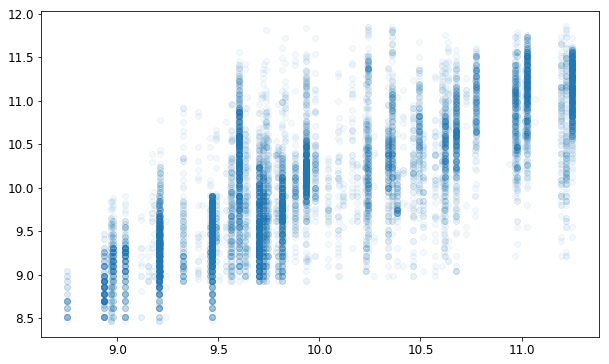

In [104]:
plt.scatter(preds, dattr.y_valid, alpha=0.05);

In [111]:
metrics.r2_score(preds, dattr.y_valid)

0.4840854669925271

In [109]:
m = RandomForestRegressor(n_estimators=1, min_samples_leaf=5, bootstrap=False)
m.fit(x_samp, y_samp)
preds_rf = m.predict(dattr.X_valid[cols].values)

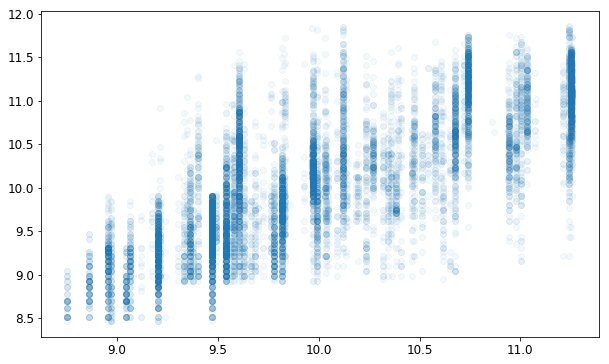

In [110]:
plt.scatter(preds_rf, dattr.y_valid, alpha=0.05);

In [112]:
metrics.r2_score(preds_rf, dattr.y_valid)

0.47541053100694797

# Putting it together

In [117]:
class TreeEnsemble():
    def __init__(self, x, y, n_trees, sample_sz, min_leaf=5, rnd_seed=42):
        np.random.seed(rnd_seed)
        self.x, self.y = x, y
        self.n_trees, self.sample_sz, self.min_leaf = n_trees, sample_sz, min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]

    def create_tree(self):
        rnd_idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        return DecisionTree(
            self.x.iloc[rnd_idxs], self.y[rnd_idxs], min_leaf=self.min_leaf)

    def predict(self, x):
        return np.mean([t.predict(x) for t in self.trees], axis=0)

In [118]:
class DecisionTree():
    def __init__(self, x, y, idxs=None, min_leaf=5):
        if idxs is None: idxs = np.arange(len(y))
        self.idxs = idxs
        self.x, self.y = x, y
        self.min_leaf = min_leaf
        self.n, self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()

    def __repr__(self):
        s = f'n:{self.n}; val:{self.val:.5f}'
        if not self.is_leaf:
            s += f'; score:{self.score:.5f}; split:{self.split:.5f}; var:{self.split_name}'
        return s

    @property
    def split_name(self):
        return self.x.columns[self.var_idx]

    @property
    def split_col(self):
        return self.x.values[self.idxs, self.var_idx]

    @property
    def is_leaf(self):
        return self.score == float('inf')

    def find_varsplit(self):
        for i in range(self.c):
            self.find_better_split(i)
        if self.is_leaf: return
        x = self.split_col
        lhs = np.nonzero(x <= self.split)[0]
        rhs = np.nonzero(x > self.split)[0]
        self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs])
        self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs])

    def find_better_split(self, var_idx):
        def std_agg(cnt, s1, s2):
            return np.sqrt((s2 / cnt) - (s1 / cnt)**2)

        x, y = self.x.values[self.idxs, var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y, sort_x = y[sort_idx], x[sort_idx]
        rhs_cnt, rhs_sum, rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
        lhs_cnt, lhs_sum, lhs_sum2 = 0, 0.0, 0.0
        for i in range(0, self.n - self.min_leaf):
            xi, yi = sort_x[i], sort_y[i]
            lhs_cnt += 1
            rhs_cnt -= 1
            lhs_sum += yi
            rhs_sum -= yi
            lhs_sum2 += yi**2
            rhs_sum2 -= yi**2
            if i < self.min_leaf - 1 or xi == sort_x[i + 1]:
                continue
            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std * lhs_cnt + rhs_std * rhs_cnt
            if curr_score < self.score:
                self.var_idx, self.score, self.split = var_idx, curr_score, xi

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx] <= self.split else self.rhs
        return t.predict_row(xi)

In [119]:
DF_RAW = pd.read_feather('tmp/bulldozers-raw')
dattr = do_proc_df(DF_RAW, N_VALID, 'SalePrice')
cols = [
    'MachineID', 'YearMade', 'MachineHoursCurrentMeter', 'ProductSize',
    'Enclosure', 'Coupler_System', 'saleYear'
]
ens = TreeEnsemble(dattr.X_train[cols], dattr.y_train, 5, 1000)
preds = ens.predict(dattr.X_valid[cols].values)

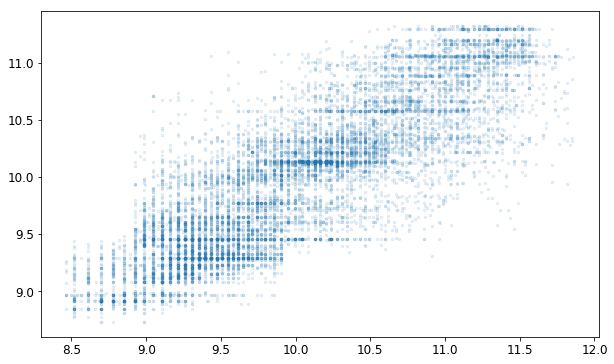

In [125]:
plt.scatter(
    dattr.y_valid, preds, alpha=0.1, s=6)

In [120]:
metrics.r2_score(dattr.y_valid, preds)

0.7025757322910476

### Cython

In [171]:
%reload_ext Cython

In [165]:
def fib(n):
    if n < 2: return n
    return fib(n - 1) + fib(n - 2)


%timeit fib(30)

249 ms ± 4.42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [166]:
%%cython
def fibc(n):
    if n < 2: return n
    return fibc(n - 1) + fibc(n - 2)

In [164]:
%timeit fibc(30)

69.4 ms ± 554 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [175]:
%%cython
cdef int fib_int(int n):
    if n < 2: return n
    return fib_int(n-2) + fib_int(n-1)


In [176]:
%timeit fib_int(30)

55.5 ms ± 634 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Exercise


So your mission now is to implement:

- Confidence based on tree variance
- Feature importance
- Partial dependence
- Tree interpreter

for that random forest. Removing redundant features doesn’t use a random forest at all, so you don’t have to worry about that. The extrapolation is not an interpretation technique so you don’t have to worry about that. So it’s just the other ones. So confidence based on tree variance, we’ve already written that code so I suspect that the exact same code we have in the notebook should continue to work. So you can try and make sure to get that working. Feature importance is with the variable shuffling technique and once you have that working, partial dependence will just be a couple of lines of code away because rather than shuffling a column, you’re just replacing it with a constant value. It’s nearly the same code.

Then tree interpreter, it’s going to require you writing some code and thinking about that. Once you’ve written tree interpreter, you’re very close, if you want to, to creating the second approach to feature importance — the one where you add up the importance across all of the rows. Which means, you would then be very close to doing interaction importance. So it turns out that there’s actually a very good library for interaction importance for xgboost but there doesn’t seem to be one for random forest, so you could start by getting it working on our version (if you want to do interaction importance) and then you could get it working on the original scikit-learn version that would be a cool contribution. Sometimes writing it against your own implementation is nicer because you can see exactly what’s going on.